In [1]:
#!pip install deap
#!pip install scikit-learn

In [2]:
import qiskit_metal as qm

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import epsilon_0
import itertools
from deap import base, creator, tools, algorithms

from qiskit_metal import designs, draw, MetalGUI, Dict, open_docs
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from collections import OrderedDict

In [4]:
design = designs.DesignPlanar()
gui = MetalGUI(design)

In [5]:
'''All SI units'''

n_qubits = 3
qubit_size = 450e-6  # 250 µm face size
qubit_size_um = qubit_size * 1e6 
freq_range = (4.5e9, 6.5e9) # Hz
chip_size = 10e-3  # 8 mm chip size
chip_size_um = chip_size * 1e6
spacing_min = 3*qubit_size  # 1.5 mm spacing between qubits
spacing_min_um = spacing_min * 1e6
spacing_max = chip_size - 2*qubit_size
spacing_max_um = spacing_max * 1e6
popn_size = 100
gens = 100
cx_probab = 0.6 # crossing
mut_probab = 0.4 # mutation

In [6]:
def gui_draw(number_qubits=1, dlt=False, hlt=False):
    """
    Purpose:
    function that helps to draw circuits without repeating same lines repeatedly.

    Takes:
    number of qubits, view clean frame after deletion, highlight the components (required for joining pads) 

    Gives:
    qiskit_metal picture
    """
    
    try:
        gui.rebuild()
        if dlt:
            gui.screenshot()
        else:
            gui.autoscale()
            all_component_names = design.components.keys()
            gui.zoom_on_components(all_component_names)
            if hlt:
                gui.highlight_components(all_component_names)
            gui.screenshot()
    except Exception as e:
        print(f"GUI rendering error: {e}")

In [7]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0, -1.0)) #maximize coupling, minimize detuning and crosstalk
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

def init_individual():
    positions = np.clip(np.random.uniform(0, chip_size_um - 2*qubit_size_um, 2 * n_qubits),  # sort of grid of points on the chip where the qubit can be
                    0, chip_size_um - 2* qubit_size_um).tolist()
    freqs = np.clip(np.random.uniform(*freq_range, n_qubits), 4.5e9, 6.5e9).tolist() 
    return positions + freqs

toolbox.register("individual", tools.initIterate, creator.Individual, init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [8]:
def coupling_model(pos_a, pos_b, P=2):
    """
    Purpose: Calculate capacitive coupling using hyperbolic approximation.
    
    Takes: position of qubits
    
    Gives: coupling cap
    """
    dx = (pos_a[0] - pos_b[0])
    dy = (pos_a[1] - pos_b[1])
    dist = np.sqrt(dx**2 + dy**2)
    
    if dist < spacing_min_um or dist > spacing_max_um:
        return float(1e8)  # Heavily penalizing overlapping qubits
    
    # Hyperbolic capacitance approximation
    C = epsilon_0 * qubit_size/ (1 + (dist / qubit_size_um) ** P)

    return max(C * 1e15, 1e-6)  # Convert to fF + avoid small values

def coupling_model(pos_a, pos_b):
    
    """
    
    Purpose: Calculate capacitive coupling using exponential decay approximation (parallel plate capacitor)
    
    Takes: position of qubits
    
    Gives: coupling cap
    
    """
    dx = (pos_a[0] - pos_b[0])
    dy = (pos_a[1] - pos_b[1])
    dist = np.sqrt(dx**2 + dy**2)
    
    if dist < spacing_min_um or dist>spacing_max_um:
        return float(1e8)  # Heavily penalizing overlapping qubits
    
    eff_area = (qubit_size_um)**2 * np.exp(-dist / (qubit_size_um))  # Exponential decay
    C = epsilon_0 * eff_area / max(dist, 1e-9)  # Capacitance formula (parallel plate)

    return max(C * 1e15, 1e-6)  # Convert to fF + avoid small values


def detuning_penalty(freqs):
    
    """
    
    Purpose: Penalize small frequency differences between qubits we don't want coupled
    
    Takes: frequencies of qubits
    
    Gives: detuning penalty
    
    """
    
    plty = 0
    for i,j in itertools.combinations(range(len(freqs)), 2):
        #if abs(i-j) > 1:  # Only non-adjacent pairs but why should adjacents miss the fun
        df = abs(freqs[i] - freqs[j])
        plty += (1 + np.exp(-(df + 0.1e9))) / (df + 0.1e9)  # a sigmoid like func for smoother punishment; heaviside was too harsh
    
    return plty


def crosstalk_penalty(positions, freqs):

    """
    Purpose: Penalize crosstalk between qubits

    Takes: qubit frequencies, positions 

    Gives: crosstalk penalty
    
    """
                            
    penalty = 0
    for i, j in itertools.combinations(range(len(freqs)), 2):
        C_ij = coupling_model(positions[i], positions[j])  # capacitance
        df_ij = abs(freqs[i] - freqs[j])
        penalty += C_ij / (df_ij + 0.1e9)  # 100 MHz safety net for ZeroDivison errors
    
    return penalty


In [9]:
def multi_objective_fitness(individual):
    
    """
    Purpose: Take all the three parameters defined above and maximize coupling (hence negated), minimize crosstalk & detuning
    
    Takes: "the individual" trinity of coupling, crosstalk penalty, detuning penalty

    Gives: tuple of all the optimization objectives
    
    """
    
    positions = np.array(individual[:2 * n_qubits]).reshape(-1, 2)
    #positions = np.clip(positions, 0, chip_size_um -2 * qubit_size_um)
    freqs = individual[-n_qubits:]
    
    boundary_penalty = 0
    for x, y in positions:
        if x < 0 or x > chip_size_um or y < 0 or y > chip_size_um:
            boundary_penalty += 1e8  # Large penalty for out of chip placement
    
    min_dist = min(np.linalg.norm(a - b) for a, b in itertools.combinations(positions, 2))
    if min_dist < spacing_min_um:
        return (1e8, 1e8, 1e8)  # big punishment

    coupling = 0
    for i in range(n_qubits - 1):
        coupling += coupling_model(positions[i], positions[i + 1])
        crosstalk = crosstalk_penalty(positions, freqs)

    freq_penalty = detuning_penalty(freqs)

    return (-coupling, crosstalk + boundary_penalty, freq_penalty + boundary_penalty)

In [10]:
toolbox.register("evaluate", multi_objective_fitness)
toolbox.register("mate", tools.cxBlend, alpha=0.5)  

def bounded_mutation(individual, mu=0, sigma=0.1, indpb=0.1):
    
    """
    
    Purpose: mutates the qubit's params (position, freq) while being inside permissible range (aka inside chip)

    Takes: individual with their positions and freqs, mean and std deviation of normal distrib. for mutations and probability of mutation

    Gives: mutated individual with mutations within permissible range

    first loop mutates positions, second: frequencies
    
    """
    
    for i in range(n_qubits*2):
        if np.random.random() < indpb:
            individual[i] += np.random.normal(mu, sigma)
            individual[i] = np.clip(individual[i], 0, chip_size)
    
    for i in range(n_qubits*2, len(individual)):
        if np.random.random() < indpb:
            individual[i] += np.random.normal(mu, sigma)
            individual[i] = np.clip(individual[i], freq_range[0], freq_range[1])
    
    return individual,


toolbox.register("mutate", bounded_mutation, mu=0, sigma=chip_size/10, indpb=0.2)
toolbox.register("select", tools.selNSGA2)  # Non-dominated Sorting Genetic Algorithm - II 

In [11]:
def run_nsga2():

    """
    Purpose: main sauce; runs the NSGA II algorithm and gives optimized formulae

    Takes: global variable

    Gives: final population after evolution, Pareto-optimal solution, log of evolution
    
    """
    
    population = [toolbox.individual() for _ in range(popn_size)]
    
    hof = tools.ParetoFront()  # Pareto: overall better params
    
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)
    
    checkpoint_freq = 10
    
    final_pop, logbook = algorithms.eaMuPlusLambda(
        population,
        toolbox,
        mu=popn_size,  # Parent population size
        lambda_=2*popn_size,  # Offspring size
        cxpb=cx_probab,  # Crossover probability
        mutpb=mut_probab,  # Mutation probability
        ngen=gens,
        stats=stats,
        halloffame=hof,
        verbose=True
    )
    
    return final_pop, hof, logbook

In [12]:
def generate_design(positions):

    """ 
    Purpose: Making the best design in Qiskit Metal

    Takes: the position of qubits in the "best" design

    Gives: Metal design
    """
    
    design.overwrite_enabled = True
    design.chips.main.size.size_x= f'{chip_size_um}um'
    design.chips.main.size.size_y= f'{chip_size_um}um'
    qubit_options = {
        'pad_width': f'{qubit_size_um}um',
        'pad_gap': '30um',
        'pocket_width': f'{qubit_size_um*1.5}um',
        'cpw_width': '10um',
        'cpw_gap': '6um',
        'hfss_inductance': '10nH',
        'layer': '0'
    }
    
    for idx, (x, y) in enumerate(positions):
        TransmonPocket(design, f'Q{idx+1}', 
                      options=dict(qubit_options, pos_x=f'{x}um', pos_y=f'{y}um'))
    
    gui_draw(n_qubits, hlt=True)
    
    return design

In [13]:
def analysis(hof):

    """
    Purpose: data analysis

    Takes: the hall of fame solutions

    Gives: the qiskit-metal design
    
    """
    
    best_ind = hof[-1]
    positions = np.array(best_ind[:2*n_qubits]).reshape(-1, 2)
    freqs = best_ind[-n_qubits:]

    print("\nOptimized Layout:") 
    for i, (x, y) in enumerate(positions):
        print(f"Q{i+1}: ({x:.1f}µm, {y:.1f}µm)")
    
    coupling_matrix = np.zeros((n_qubits, n_qubits))
    for i,j in itertools.combinations(range(n_qubits), 2):
        coupling_matrix[i,j] = coupling_model(positions[i], positions[j])               # calculatse coupling metrics
        coupling_matrix[j,i] = coupling_model(positions[i], positions[j])
    print("\nCoupling Matrix (fF):")
    print(coupling_matrix)
    
    return generate_design(positions)


gen	nevals	avg                                                    	std                                                    	min                                              	max                   
0  	100   	[14994982.35306826 17000000.01843094 17000000.        ]	[40929178.7752425  37563279.93364462 37563279.9419859 ]	[-1.00020503e+08  4.58720817e-10  2.84931543e-09]	[1.e+08 1.e+08 1.e+08]
1  	200   	[-11006949.93845473   2000000.02597144   2000000.        ]	[34336027.89945933 19899748.77041244 19899748.7421324 ]	[-2.00000000e+08  4.58720817e-10  1.99941956e-09]	[-1.38787918e-02  2.00000000e+08  2.00000000e+08]
2  	200   	[-17009391.99490352   5000000.04145809   5000000.        ]	[42555020.96191844 29580398.99701594 29580398.91549808]	[-2.00000000e+08  4.58720817e-10  1.99941956e-09]	[-2.52711286e-01  2.00000001e+08  2.00000000e+08]
3  	200   	[-16009819.90005466   5000000.03381938   5000000.        ]	[41761107.77619573 29580398.9983071  29580398.91549808]	[-2.00000000e+08  1.52158589e-

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


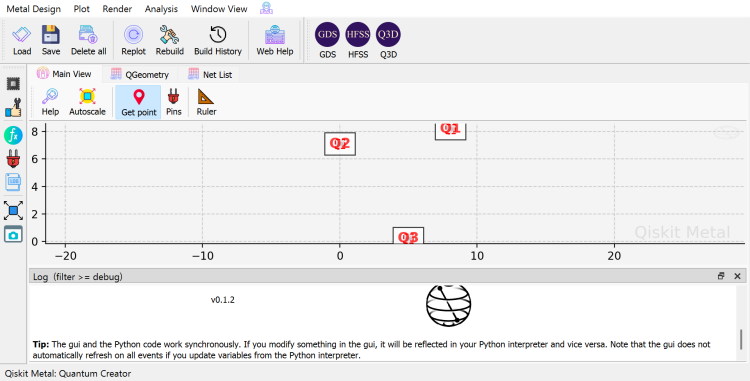

In [14]:
population, hof, logbook = run_nsga2()

gen, avg, min_, max_ = logbook.select("gen", "avg", "min", "max")

plt.figure(figsize=(10, 6))


plt.plot(gen, avg, 'o-', label="Average Fitness", color='blue', linewidth=2)
plt.plot(gen, min_, 's--', label="Minimum Fitness", color='red', linewidth=2)
plt.plot(gen, max_, 'd-.', label="Maximum Fitness", color='green', linewidth=2)

plt.xlabel("Generation")
plt.ylabel("Fitness (MHz)")
plt.title("Optimization Progression")

plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="best", fontsize=12)
plt.show()

optimized_design = analysis(hof)